In [2]:
from datasets import load_dataset

dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree")
dataset

/Users/ryanvu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [4]:
data = dataset['train'].shuffle(seed = 42)

split = data.train_test_split(test_size = 0.3)
train_data = split['train'] # training data 70%
temp = split['test'] # temporary data to split further

test_split = temp.train_test_split(test_size = 0.5)
val_data = test_split['train'] # validation data 15%
test_data = test_split['test'] # testing data 15%

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = 'ProsusAI/finbert'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 3)

/Users/ryanvu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Tokenizing text

def preprocess(examples):
    return tokenizer(examples["sentence"], padding = "max_length", truncation = True, max_length = 128)

train_tokenized = train_data.map(preprocess, batched = True, batch_size = 32)
val_tokenized = val_data.map(preprocess, batched = True, batch_size = 32)
test_tokenized = test_data.map(preprocess, batched = True, batch_size = 32)

# Set format for PyTorch -> to train with PyTorch

train_tokenized.set_format("torch", columns = ["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns = ["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1584 [00:00<?, ? examples/s]

Map: 100%|██████████| 340/340 [00:00<00:00, 2543.81 examples/s]


In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = '../models/finbert_finetuned1',
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 5,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    logging_dir = '../logs',
    load_best_model_at_end = True
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_tokenized,
    eval_dataset = val_tokenized
)

In [7]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: csprojects47 (csprojects47-university-of-british-columbia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.197625
2,No log,0.219896
3,0.187200,0.171559
4,0.187200,0.175815
5,0.187200,0.173325


TrainOutput(global_step=990, training_loss=0.10540583446772411, metrics={'train_runtime': 270.4533, 'train_samples_per_second': 29.284, 'train_steps_per_second': 3.661, 'total_flos': 520964567101440.0, 'train_loss': 0.10540583446772411, 'epoch': 5.0})

In [8]:
metrics = trainer.evaluate(test_tokenized)
print(metrics)

{'eval_loss': 0.27507832646369934, 'eval_runtime': 2.3162, 'eval_samples_per_second': 146.793, 'eval_steps_per_second': 18.565, 'epoch': 5.0}


In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

preds = trainer.predict(test_tokenized)

y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis = 1)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Accuracy:  0.9500
F1 Score:  0.9495
Precision: 0.9493
Recall:    0.9500


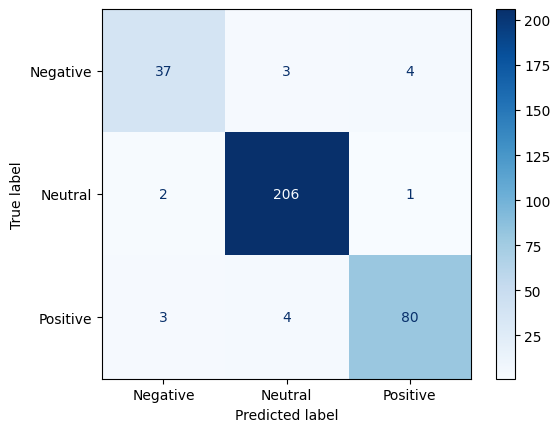

In [10]:
import matplotlib as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues)